<div style="position:relative; float:right"><img style="height:125px" src ="notebook_images/1200px-Star_wars2.svg.png" />
</div>
<div id="container" style="position:relative;">
<div style="float:left"><h1> Image Restoration with Deep Learning </h1></div>
<div id="container" style="position:relative;">
<div style="float:left"><h3> Episode VI: Deep Learning Modeling - Transfer Learning</h3></div>
<div style="float:left"><h1> </h1></div>
</div>

Author: Elaheh Shakeri
<br>
Email: elahehshakeri3@gmail.com
<br>
Date: 12th December, 2022
<br>
Notebook 4 out of 4

## Table of Contents

[Introduction](#Introduction)
<br>
[Evaluation Metrics](#Evaluation-Metrics)
<br>
[Loading, Preprocessing and Modeling the Data](#Loading,-Preprocessing-and-Modeling-the-Data)
<br>
[Transfer Learning: EfficientNetB0](#Transfer-Learning:-EfficientNetB0)

## Introduction

We attempted to implement transfer learning in our modeling as well.

Transfer Learning is applying knowledge gained (weight values) from a trained neural network model onto a different but related problem.

However, during the limited time that we had for our capstone project, we were only able to find trained models that were trained for image classification or image segmentation problems. The problem with using these trained models as a transfer model for our project is that what models learn for image classification or segmentation is different than what a model needs to learn for image restoration.

We still attempted to use a EfficientNetB0 model with trained weights for our problem.

In [3]:
# Imports
# The usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import os, sys
import cv2
import joblib
import glob
import math

# Importing tf tools
import tensorflow as tf
import tf_slim as slim
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, ReLU, MaxPooling2D,UpSampling2D,LeakyReLU, Dropout,BatchNormalization,Activation,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from keras import backend as K

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Evaluation Metrics

- #### Mean Squared Error (MSE)

In [ ]:
def MSE(y_true, y_pred):
  '''
  INPUT: two images
  OUTPUT: the mean squared error between the input images
  '''
  err = np.sum((y_true.astype("float") - y_pred.astype("float")) ** 2) # sum of the squared difference between the pixels of the two images
  err /= float(y_true.shape[0] * y_true.shape[1]) # divide the error by the number pixels
  return err # returning error which is the MSE

- #### Peak Signal to Noise Ratio (PSNR)

In [ ]:
def PSNR(y_true, y_pred):
  '''
  INPUT: two images
  OUTPUT: the PSNR of the two images
  '''
  return tf.image.psnr(y_pred, y_true, max_val=1.0) #the max_val is the maximum pixel value in the images, since we have normalized our images, this value is 1

- #### Structural Similarity Index Measure (SSIM)

In [ ]:
def SSIM(y_true, y_pred):
  '''
  INPUT: two images
  OUTPUT: the SSIM of the two images
  '''
  return tf.image.ssim(y_pred, y_true, max_val=1.0) #the max_val is the maximum pixel value in the images, since we have normalized our images, this value is 1

## Loading, Preprocessing and Modeling the Data

The dataset is stored onto our Google drive, since this notebook was ran on Google Colab, we will mount this notebook on Google drive and unzip the file.

In [5]:
!unzip '/content/gdrive/My Drive/capstone_images2'

Archive:  /content/gdrive/My Drive/capstone_images2.zip
replace input_test/0000000544.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
cd '/content/'

/content


This contents of this notebook is from a few weeks back when we didnt know that relaying on the genartor to split the images into train and validation was not a reliable method.

Also, we performed the the transfer learning model on the entire dataset, which limited our ability to train the model for longer periods of time due to the time and computational restrictions we had.

In [7]:
# Specify directories to the train and test input and output datasets from our google drive
INPUT_TRAIN = 'input_train'
INPUT_TEST = 'input_test'

OUTPUT_TRAIN = 'output_train'
OUTPUT_TEST = 'output_test'

In [8]:
# defining the batch size
batch_size = 32

In [23]:
# loading the train and validation data with .image_dataset_from_directory while changing the image size and batching the data
input_train = tf.keras.utils.image_dataset_from_directory(
    INPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False,
    seed=27,
    validation_split=0.15,
    subset='training')

input_validation = tf.keras.utils.image_dataset_from_directory(
    INPUT_TRAIN,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False,
    seed=27,
    validation_split=0.15,
    subset='validation')

Found 27007 files belonging to 1 classes.
Using 22956 files for training.
Found 27007 files belonging to 1 classes.
Using 4051 files for validation.


In [24]:
# we have different generators for the outputs (groundtruth) of the train and validation data
output_train = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=(256, 256),
    shuffle=True,
    seed=27,
    validation_split=0.15,
    subset='training')

output_validation = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=(256, 256),
    shuffle=True,
    seed=27,
    validation_split=0.15,
    subset='validation')

Found 27007 files belonging to 1 classes.
Using 22956 files for training.
Found 27007 files belonging to 1 classes.
Using 4051 files for validation.


In [25]:
# we use a map function to normalize images
X_train = input_train.map(lambda X_train: X_train/255)

y_train = output_train.map(lambda y_train: y_train/255)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
train = tf.data.Dataset.zip((X_train, y_train))

In [26]:
# we use a map function to normalize images
X_val = input_validation.map(lambda X_val: X_val/255)

y_val = output_validation.map(lambda y_val: y_val/255)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
validation = tf.data.Dataset.zip((X_val, y_val))

In [ ]:
# loading the test input and output data with .image_dataset_from_directory while changing the image size and batching the data
input_test = tf.keras.utils.image_dataset_from_directory(
    INPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=(256, 256),
    batch_size=batch_size)

output_test = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=(256, 256),
    batch_size=batch_size)

Found 4768 files belonging to 1 classes.
Found 4768 files belonging to 1 classes.


In [ ]:
# we use a map function to normalize images
X_test = input_test.map(lambda X_test: X_test/255)

y_test = output_test.map(lambda y_test: y_test/255)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
test = tf.data.Dataset.zip((X_test, y_test))

## Transfer Learning: EfficientNetB0

EfficientNetB0 has an encoder structure. The goal was to use the structure and the weights of EfficientNetB0 as the encoder section of our convolutional autoencoder and then attach a decoder to it.

In [13]:
# we load the pretrained  EfficientNetB0 model from tensorflow
from tensorflow.keras.applications import EfficientNetB0

In [14]:
# we load the weight and set the image target size
model = EfficientNetB0(weights='imagenet',
                   include_top=False,
                   input_shape= (256, 256, 3))

In [15]:
output = model.output
output

<KerasTensor: shape=(None, 8, 8, 1280) dtype=float32 (created by layer 'top_activation')>

In [16]:
# we freeze the weights in the model and set it layers to be not trainable
for layer in model.layers:
    layer.trainable=False

In [84]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

After freezing the 4,049,571 parameters of the EfficientNetB0 structure, we mirror its structure as a decoder and attach it to the EfficientNetB0 structure. We set the output of the EfficientNet to be the input of our decoder and then only train the decoder part of our model.

In [17]:
transfer_model= Conv2DTranspose(516,(2,2),strides=(2, 2))(output)
transfer_model= ReLU(0.1)(transfer_model)
transfer_model= BatchNormalization()(transfer_model)

transfer_model= Conv2DTranspose(256,(2,2),strides=(2, 2),padding='same')(transfer_model)
transfer_model= ReLU(0.1)(transfer_model)
transfer_model= BatchNormalization()(transfer_model) 

transfer_model= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(transfer_model)
transfer_model= ReLU(0.1)(transfer_model)
transfer_model= BatchNormalization()(transfer_model)

transfer_model= Conv2D(64,(3,3),strides=(1, 1),padding='same')(transfer_model)  
transfer_model= ReLU(0.1)(transfer_model)
transfer_model= BatchNormalization()(transfer_model)

transfer_model= Conv2DTranspose(32,(2,2),strides=(2, 2),padding='same')(transfer_model)
transfer_model= ReLU(0.1)(transfer_model)
transfer_model= BatchNormalization()(transfer_model)

transfer_model= Conv2D(16,(3,3),strides=(1, 1),padding='same')(transfer_model)  
transfer_model= ReLU(0.1)(transfer_model)
transfer_model= BatchNormalization()(transfer_model)

transfer_model= Conv2DTranspose(8,(2,2),strides=(2, 2),padding='same')(transfer_model)
transfer_model= ReLU(0.1)(transfer_model)
transfer_model= BatchNormalization()(transfer_model)

transfer_model= Conv2D(3,(3,3),strides=(1, 1),padding='same')(transfer_model)
transfer_model= ReLU(0.1)(transfer_model)
transfer_model= BatchNormalization()(transfer_model)

transfer_model= Model(model.input,transfer_model)

In [13]:
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['normalization[0][0]']      

we then complied the model with its Optimizer as the Adam algorithm with a learning rate of 1e-3. We set MSE as the loss function and PSNR and SSIM as the evaluation metrics.

We did various attempts with different epochs and learning rates however none of them resulted in good data. 

The future goal is to find a trained model that has been trained for denoising, deblurring or similar task and transfer that model to our problem.

In [26]:
transfer_model.compile(optimizer = Adam(learning_rate = 1e-3), 
               loss = 'mean_squared_error', 
               metrics = [PSNR, SSIM])

In [27]:
history = transfer_model.fit(train,
                     epochs=10,
                     validation_data=validation,
                     verbose=1)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:2212: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:1345: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


718/718 [==============================] - 264s 342ms/step - loss: 0.1288 - PSNR: 11.5278 - SSIM: 0.3435 - val_loss: 0.0494 - val_PSNR: 13.1161 - val_SSIM: 0.3158
Epoch 2/10
718/718 [==============================] - 244s 338ms/step - loss: 0.0488 - PSNR: 13.1706 - SSIM: 0.3169 - val_loss: 0.0494 - val_PSNR: 13.1219 - val_SSIM: 0.3160
Epoch 3/10
718/718 [==============================] - 240s 333ms/step - loss: 0.0488 - PSNR: 13.1689 - SSIM: 0.3169 - val_loss: 0.0494 - val_PSNR: 13.1192 - val_SSIM: 0.3158
Epoch 4/10
718/718 [==============================] - 218s 301ms/step - loss: 0.0488 - PSNR: 13.1746 - SSIM: 0.3169 - val_loss: 0.0494 - val_PSNR: 13.1163 - val_SSIM: 0.3159
Epoch 5/10
718/718 [==============================] - 216s 299ms/step - loss: 0.0488 - PSNR: 13.1702 - SSIM: 0.3169 - val_loss: 0.0494 - val_PSNR: 13.1226 - val_SSIM: 0.3160
Epoch 6/10
718/718 [==============================] - 221s 306ms/step - loss: 0.0488 - PSNR: 13.1729 - SSIM: 0.3169 - val_loss: 0.0494 - val_

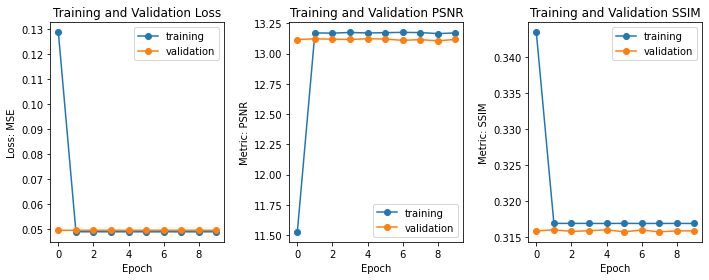

In [31]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history.history['loss'], marker='o', label='training')
plt.plot(history.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history.history['PSNR'], marker='o', label='training')
plt.plot(history.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history.history['SSIM'], marker='o', label='training')
plt.plot(history.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

In [30]:
input_test = tf.keras.utils.image_dataset_from_directory(
    INPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=(256, 256),
    batch_size=batch_size)

output_test = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=(256, 256),
    batch_size=batch_size)

Found 4768 files belonging to 1 classes.
Found 4768 files belonging to 1 classes.


In [31]:
X_test = input_test.map(lambda X_test: X_test/255)

y_test = output_test.map(lambda y_test: y_test/255)

test = tf.data.Dataset.zip((X_test, y_test))

In [34]:
transfer_model.evaluate(test, verbose=1)

149/149 [==============================] - 42s 255ms/step - loss: 0.0488 - PSNR: 13.1830 - SSIM: 0.3158


[0.04875493049621582, 13.183039665222168, 0.3158281445503235]

In [69]:
transfer_model.compile(optimizer = Adam(learning_rate = 2e-5), 
               loss = 'mean_squared_error', 
               metrics = [PSNR, SSIM])

In [70]:
history = transfer_model.fit(train,
                     epochs=25,
                     validation_data=validation,
                     verbose=1)

Epoch 1/25
718/718 [==============================] - 215s 289ms/step - loss: 0.4641 - PSNR: 3.3535 - SSIM: 0.5610 - val_loss: 0.3721 - val_PSNR: 4.2941 - val_SSIM: 0.5836
Epoch 2/25
718/718 [==============================] - 206s 285ms/step - loss: 0.2920 - PSNR: 5.4257 - SSIM: 0.4988 - val_loss: 0.1997 - val_PSNR: 7.0002 - val_SSIM: 0.4242
Epoch 3/25
718/718 [==============================] - 209s 290ms/step - loss: 0.1424 - PSNR: 8.5715 - SSIM: 0.3411 - val_loss: 0.0983 - val_PSNR: 10.0923 - val_SSIM: 0.3249
Epoch 4/25
718/718 [==============================] - 222s 308ms/step - loss: 0.0798 - PSNR: 11.0356 - SSIM: 0.3201 - val_loss: 0.0681 - val_PSNR: 11.7045 - val_SSIM: 0.3167
Epoch 5/25
718/718 [==============================] - 210s 291ms/step - loss: 0.0610 - PSNR: 12.1913 - SSIM: 0.3160 - val_loss: 0.0572 - val_PSNR: 12.4783 - val_SSIM: 0.3147
Epoch 6/25
718/718 [==============================] - 206s 286ms/step - loss: 0.0543 - PSNR: 12.7069 - SSIM: 0.3152 - val_loss: 0.0533 

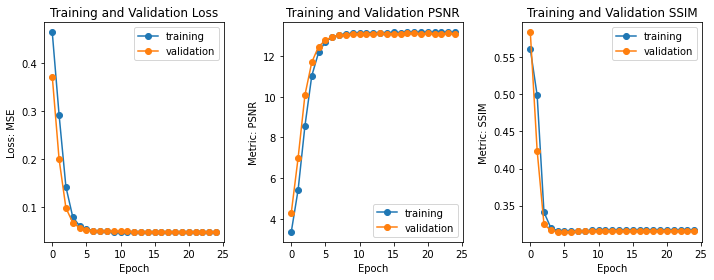

In [71]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history.history['loss'], marker='o', label='training')
plt.plot(history.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history.history['PSNR'], marker='o', label='training')
plt.plot(history.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history.history['SSIM'], marker='o', label='training')
plt.plot(history.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

In [72]:
transfer_model.evaluate(test, verbose=1)

149/149 [==============================] - 43s 274ms/step - loss: 0.0487 - PSNR: 13.1685 - SSIM: 0.3163


[0.048744309693574905, 13.168508529663086, 0.31634241342544556]

In [ ]:
transfer_predictions = transfer_model.predict(X_test)

In [ ]:
plt.imshow(transfer_predictions[78])
plt.show()

In [27]:
transfer_model.compile(optimizer = Adam(learning_rate = 1e-2), 
               loss = 'mean_squared_error', 
               metrics = [PSNR, SSIM])

In [28]:
history = transfer_model.fit(train,
                     epochs=10,
                     validation_data=validation,
                     verbose=1)

Epoch 1/10
718/718 [==============================] - 241s 322ms/step - loss: 0.0488 - PSNR: 13.1612 - SSIM: 0.3169 - val_loss: 0.0495 - val_PSNR: 13.1032 - val_SSIM: 0.3155
Epoch 2/10
718/718 [==============================] - 237s 328ms/step - loss: 0.0488 - PSNR: 13.1649 - SSIM: 0.3169 - val_loss: 0.0495 - val_PSNR: 13.1133 - val_SSIM: 0.3171
Epoch 3/10
718/718 [==============================] - 221s 306ms/step - loss: 0.0488 - PSNR: 13.1637 - SSIM: 0.3170 - val_loss: 0.0494 - val_PSNR: 13.1161 - val_SSIM: 0.3161
Epoch 4/10
718/718 [==============================] - 214s 297ms/step - loss: 0.0488 - PSNR: 13.1696 - SSIM: 0.3169 - val_loss: 0.0496 - val_PSNR: 13.0940 - val_SSIM: 0.3144
Epoch 5/10
718/718 [==============================] - 234s 324ms/step - loss: 0.0488 - PSNR: 13.1657 - SSIM: 0.3169 - val_loss: 0.0494 - val_PSNR: 13.1091 - val_SSIM: 0.3178
Epoch 6/10
718/718 [==============================] - 229s 317ms/step - loss: 0.0488 - PSNR: 13.1652 - SSIM: 0.3170 - val_loss: 0.

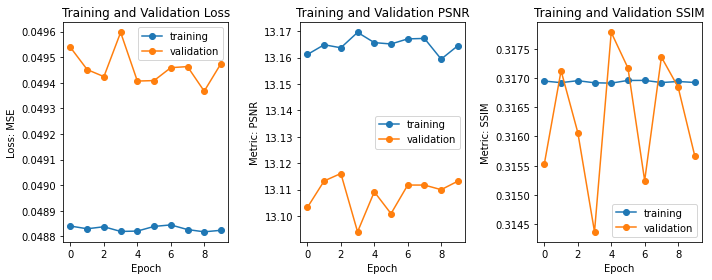

In [29]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history.history['loss'], marker='o', label='training')
plt.plot(history.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history.history['PSNR'], marker='o', label='training')
plt.plot(history.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history.history['SSIM'], marker='o', label='training')
plt.plot(history.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

In [32]:
transfer_model.evaluate(test, verbose=1)

149/149 [==============================] - 44s 275ms/step - loss: 0.0488 - PSNR: 13.1742 - SSIM: 0.3156


[0.04881485924124718, 13.174209594726562, 0.31558987498283386]

In [33]:
transfer_predictions = transfer_model.predict(X_test)

149/149 [==============================] - 21s 115ms/step


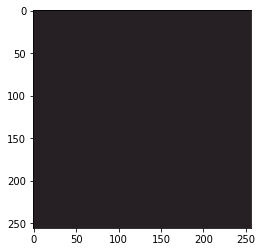

In [36]:
plt.imshow(transfer_predictions[1980])
plt.show()